In [27]:
import pandas as pd 
import numpy as np
import folium
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from IPython.display import display

## Ingest Data
- preprocessed_eviction_data.csv is generated from ingest_data.py, containing cleaned and preprocessed eviction data.

In [28]:
df = pd.read_csv('preprocessed_eviction_data.csv')

## Exploratory Data Analysis

In [29]:
from eda import EvictionVisualizer 
viz = EvictionVisualizer(df)
counts = viz.get_eviction_counts()
print(counts)

Executed Date  2017-01-03  2017-01-04  2017-01-05  2017-01-06  2017-01-09  \
BOROUGH                                                                     
BRONX                  38          44          47          48          22   
BROOKLYN               13          51          17          55          40   
MANHATTAN              27          10          21          12          18   
QUEENS                 17          18          23          22          12   
STATEN ISLAND           4           5           3           1           1   

Executed Date  2017-01-10  2017-01-11  2017-01-12  2017-01-13  2017-01-17  \
BOROUGH                                                                     
BRONX                  35          34          38          30          29   
BROOKLYN               14          42          22          24          15   
MANHATTAN              30           9          17          13          25   
QUEENS                 15          20          17          24          24  

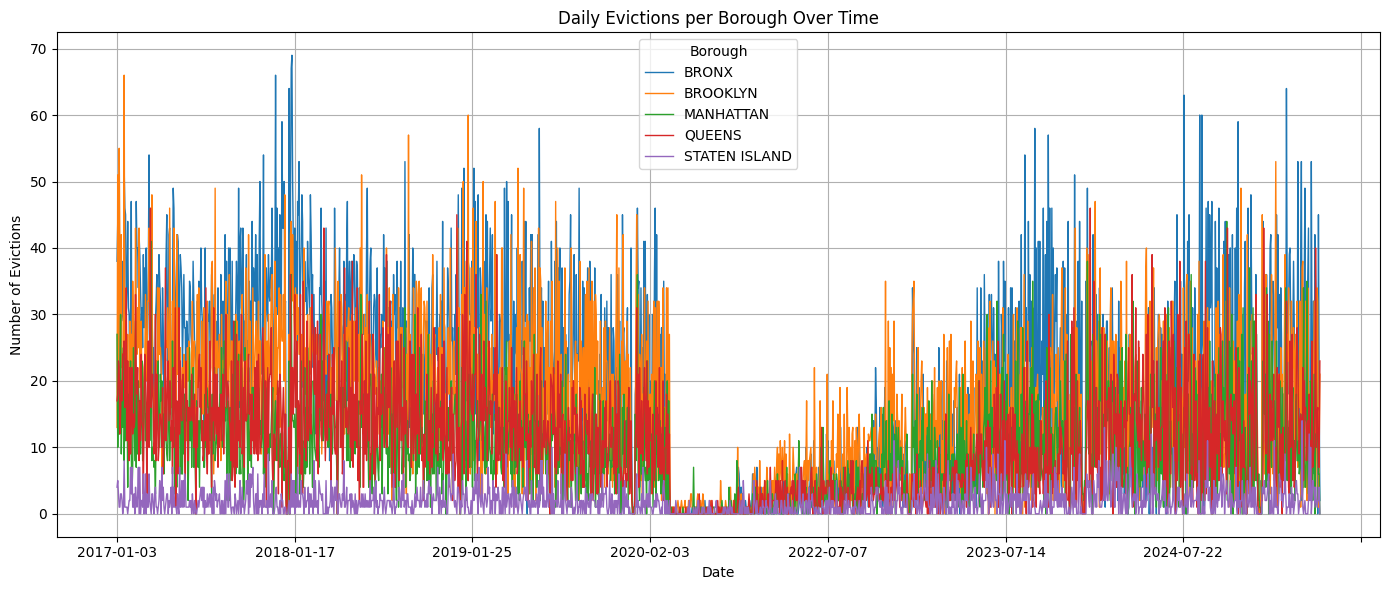

In [30]:
viz.plot_evictions_over_time()

Plotting the evictions per day from January 3rd, 2017 to May 2nd, 2025 shows that the Bronx and Brooklyn are the boroughs that experience the highest number of evictions per day. There is a drastic drop in evictions from February 3rd, 2020 to July 7th, 2022, attesting to the quality of this data by showing that the number of evictions during the COVID-19 pandemic significantly dropped then began increasing after the pandemic.

To explore geospatial patterns, the latitude and longitude for each eviction will be binned to 3 decimal places. Because New York City is an extremely densely populated city with a relatively small area, the raw latitude and longitude may be difficult for usage in clustering due to being very specific. Grouping it into bins of roughly one block size can provide a more accurate representation of the geographic distribution of evictions. This binning will be used for the rest of the downstream analysis.

In [31]:
viz.plot_time_series_heatmap()

In [32]:
viz.plot_static_heatmap()

Plotting the changes in eviction counts over time from 2017 to 2025 (ranges from January 3rd, 2017 to May 2nd, 2025) shows that the West Bronx and East Flatbush areas experience a high number of evictions every single day while other areas in other boroughs are relatively stable, experiencing very few evictions if at all each day. Finding the mean coordinates for these boroughs can find, quite literally, the center of evictions in each borough for each year to understand neighborhoods that consistently have high eviction rates.

In [33]:
bronx_df = df[df['BOROUGH'] == 'BRONX']
viz_bronx = EvictionVisualizer(bronx_df)
geo_bronx = viz_bronx.get_geo_df()
geo_bronx = geo_bronx.drop(['Executed Date'], axis=1)
geo_bronx.mean()

Latitude       40.849014
Longitude     -73.888657
Year         2020.051256
lat_bin        40.849007
lon_bin       -73.888653
dtype: float64

In [34]:
mean_lat_lon = geo_bronx.groupby('Year')[['lat_bin', 'lon_bin']].mean()
mean_lat_lon = mean_lat_lon.round(3)
print(mean_lat_lon)

      lat_bin  lon_bin
Year                  
2017   40.850  -73.889
2018   40.849  -73.889
2019   40.848  -73.888
2020   40.849  -73.889
2021   40.850  -73.891
2022   40.851  -73.886
2023   40.849  -73.889
2024   40.848  -73.889
2025   40.848  -73.889


In [35]:
brooklyn_df = df[df['BOROUGH'] == 'BROOKLYN']
viz_brooklyn = EvictionVisualizer(brooklyn_df)
geo_brooklyn = viz_brooklyn.get_geo_df()
geo_brooklyn = geo_brooklyn.drop(['Executed Date'], axis=1)
geo_brooklyn.mean()

Latitude       40.655736
Longitude     -73.939833
Year         2020.200528
lat_bin        40.655742
lon_bin       -73.939825
dtype: float64

In [36]:
mean_lat_lon = geo_brooklyn.groupby('Year')[['lat_bin', 'lon_bin']].mean()
mean_lat_lon = mean_lat_lon.round(3)
print(mean_lat_lon)

      lat_bin  lon_bin
Year                  
2017   40.656  -73.938
2018   40.655  -73.938
2019   40.657  -73.938
2020   40.655  -73.943
2021   40.657  -73.951
2022   40.655  -73.945
2023   40.655  -73.943
2024   40.656  -73.940
2025   40.656  -73.941


Taking the mean latitude and longitude for each year in the Bronx (based on bins, and rounding to place mean in bins), it is shown that the centroid of eviction points is in 40.850, -73.889, with slight changes each year. This is roughly in the West Bronx. This corresponds to assembly district 86, which had the 2nd highest eviction filing rate (alongside assembly district 78 which ranked 1st, comprising Fordham and Belmont, just north of the West Bronx). 

[Bronx sees second highest eviction filing rate in the state, with data revealing hot spots in the borough](https://www.bxtimes.com/bronx-eviction-filing-rate-state-data/)

Taking the mean latitude and longitude for each year in Brooklyn (based on bins, and rounding to place mean in bins), it is shown that the centroid of eviction points is in 40.656, -73.940, with slight changes each year. This is roughly in the East Flatbush and Crown Heights areas. This corresponds to assembly district 58.

To explore these neighborhoods further, and groups of neighborhoods with similar eviction patterns, we can perform clustering to create clusters that reflect geospatial patterns. The goal of this clustering would be to identify groups of neighborhoods that have consistent evictions each day, and groups of neighborhoods that rarely experience evictions.

## Feature Generation

To perform clustering in order to find geospatial hotspots, where evictions are most frequent and at high numbers, a pivoted version of the eviction data can be created, where each row represents a longitude and latitude pair, and each column represents a particular date. The values in this dataframe will be the number of evictions for that location and date. 

pivot_df will be used to find the most frequent evictions and where these evictions occur in the dataset. This will be used to do some feature engineering for the clustering model, most notably creating weights for each lat_lon pair so that areas with more evictions are given more weight in the clustering model.

In [117]:
from feat_gen import pivot_data
pivot_df, df_geo = pivot_data(df)
print(pivot_df)

Executed Date                                             2017-01-03  \
lat_lon           NTA                                                  
(40.499, -74.241) Charleston-Richmond Valley-Tottenville         0.0   
(40.5, -74.239)   Charleston-Richmond Valley-Tottenville         0.0   
(40.502, -74.239) Charleston-Richmond Valley-Tottenville         0.0   
(40.502, -74.237) Charleston-Richmond Valley-Tottenville         0.0   
(40.503, -74.244) Charleston-Richmond Valley-Tottenville         0.0   
...                                                              ...   
(40.907, -73.897) North Riverdale-Fieldston-Riverdale            0.0   
(40.907, -73.85)  Woodlawn-Wakefield                             0.0   
(40.908, -73.907) North Riverdale-Fieldston-Riverdale            0.0   
(40.91, -73.897)  North Riverdale-Fieldston-Riverdale            0.0   
(40.912, -73.903) North Riverdale-Fieldston-Riverdale            0.0   

Executed Date                                             2017-

## Clustering

After some trial and error with k-means, DBSCAN, and HDBSCAN, we landed on using a Bayesian Gaussian Mixture Model (BGMM) for clustering. BGMMs are a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. We did a pseudo-weighting system where locations would be more frequent if they experience a high number of evictions over the 8 year period (2017-2025). That is: for lat_lon pair $X$,the total eviction count of $X$, $n_X$, the pseudo weight $w(X)$ and frequency $f(X)$ :

$$ f(X) =  w(X) = \min(n_X, 20)$$

Such that the location $X$ would be replicated $f(X)$ times in the dataset (20 is chosen as an arbitrary cap to avoid overrepresentation). Although it is not the best way of weighing locations by evication count, it improves the geospatial clustering compared to k-means and DBSCAN, which often just outlined clusters of locations without taking into account the frequency of evictions (for example, the first k-means just created clusters that were just each borough).

This weighted data would then be fed into a Bayesian Gaussian Mixture Model (BGMM) to identify clusters of locations that are geographically similar and have similar eviction frequencies. The structure of the data would be $x = (X_1, X_2)$ where $X_1$ is the binned latitude and $X_2$ is the binned longitude. This works particularly well for the Gaussian mixture model since it is sensitive to the density of points since it creates estimated Gaussian distributions based on the underlying data.

In [118]:
from model_creation import create_bgmm
bgmm, cluster_map= create_bgmm(pivot_df)

/usr/local/lib/python3.11/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


In [119]:
pivot_df['cluster'] = cluster_map

In [120]:
cluster_counts = pivot_df.groupby('cluster').size().reset_index(name='eviction_count')
cluster_counts = cluster_counts.sort_values('eviction_count', ascending=False)
print(cluster_counts)

    cluster  eviction_count
5         5            1101
15       15             957
19       19             892
2         2             821
10       10             791
12       12             748
28       28             742
7         7             679
27       27             614
17       17             611
23       23             608
14       14             606
26       26             529
18       18             521
1         1             484
24       24             478
22       22             460
29       29             455
0         0             453
16       16             391
4         4             385
13       13             357
9         9             353
6         6             336
11       11             319
8         8             292
21       21             284
3         3             271
25       25             186
20       20             138


In [121]:
df_geo = df_geo.merge(pivot_df[['cluster']], left_on=['lat_lon', 'NTA'], right_index=True)

## Clustering Evaluation

Now that the Bayesian Gaussian Mixture Model (BGMM) has been created and clusters have been identified, we can evaluate the results. To evaluate the effectiveness of the clustering in identifying geospatial hotspots, the top and bottom 3 clusters will be plotted as a time series.

In [122]:
from model_eval import cluster_time_series
clusters_to_include = [5, 15, 19]

cluster_time_series(df_geo, clusters_to_include)

   cluster                                                NTA
0        5  [Seagate-Coney Island, Sheepshead Bay-Gerritse...
1       15  [Mott Haven-Port Morris, West Farms-Bronx Rive...
2       19  [Crown Heights North, Rugby-Remsen Village, Oc...


Plotting the time series for the clusters with the top 3 eviction counts shows specific areas in the Bronx and Brooklyn that have multiple evictions each day, with the exception of days ranging the COVID-19 pandemic. These clusters are mainly centered around Seagate-Coney Island and Sheepshead Bay (Cluster 5), Mott Haven-Port Morris and West Farms (Cluster 15), and Crown Heights North and Rugby-Remsen Village(Cluster 19).

These areas correspond to earlier exploratory data analysis that showed that the center of evictions in the Bronx was near the West Bronx (cluster 15 is a bit farther from this area but still adjacent) and in Crown Heights in Brooklyn. This indicates that the Bayesian Gaussian Mixture Model (BGMM) successfully identified these areas as geospatial hotspots where evictions are high and frequently occurring. 

In [123]:
clusters_to_include = [3, 25, 20]
cluster_time_series(df_geo, clusters_to_include)

   cluster                                                NTA
0        3  [Mariner's Harbor-Arlington-Port Ivory-Granite...
1       20  [Soundview-Castle Hill-Clason Point-Harding Pa...
2       25  [Bronxdale, Pelham Parkway, Williamsbridge-Oli...


On the other hand, plotting the time series for the clusters with the bottom 3 eviction counts shows specific areas in the Bronx and Staten Island that have very few evictions each day if at all. These is quite interesting as two of the clusters are located in the Bronx which previosly was established as a hotspot for evictions. This indicates that high eviction rates may not be widespread across the Bronx, but are rather concentrated in specific areas that cause the borough to have high eviction rates overall. Conversely, one of the clusters is in Staten Island, which consistently has very few evictions. This again validates the effectiveness of the Bayesian Gaussian Mixture Model (BGMM) in also identifying the opposite of geospatial hotspots, that being areas with very few evictions.

The model also gives insight into neighborhoods that are in boroughs that have consistent evictions each day, but actualy have very few evictions. This may reveal neighborhoods that are actually "protected" in a sense from high eviction rates that neighbor them.


## Merging with NTA Data

In order to explore trends that may impact the clusters with the most and least eviction counts, we can merge demographic NTA data with the geospatial data. We can also label clusters as beiing low, moderate, or high risk of evictions based on the eviction count.

In [124]:
stats = cluster_counts.describe()
pct_25 = stats.loc['25%', 'eviction_count']
pct_75 = stats.loc['75%', 'eviction_count']

In [125]:
cluster_counts['Eviction Risk'] = 'Moderate'
cluster_counts.loc[cluster_counts['eviction_count'] < pct_25, 'Eviction Risk'] = 'Low'
cluster_counts.loc[cluster_counts['eviction_count'] > pct_75, 'Eviction Risk'] = 'High'

In [126]:
df_geo = df_geo.merge(cluster_counts[['cluster', 'Eviction Risk']], left_on='cluster', right_on='cluster')

Unfortunately, because so much census data is being taken down, we were only able to find the demographic data of NTAs for 2020. This will be merged onto our geospatial data.

In [127]:
demograpic_data = pd.read_csv('2020-Demographic_NTA.csv')
demograpic_data = demograpic_data.drop(['NTA Code', 'Borough ', 'Borough CD'], axis=1)

In [128]:
df_geo['year'] = pd.DatetimeIndex(df_geo['Executed Date']).year
geo_2020 = df_geo[df_geo['year'] == 2020]

In [129]:
geo_demo_2020 = geo_2020.merge(demograpic_data, on='NTA')
geo_demo_2020 = geo_demo_2020.drop(['year', 'Executed Date', 'lat_lon', 'cluster'], axis=1)

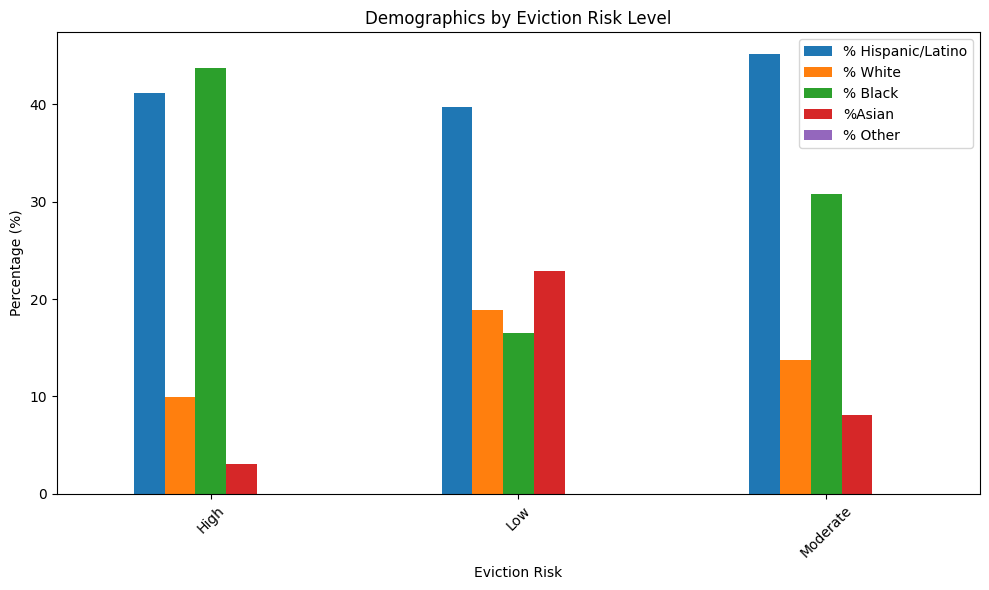

In [130]:
from model_eval import graph_demographic
graph_demographic(geo_demo_2020)

A visualization of the average percentage of each demographic group in the eviction risk levels shows that areas with high eviction rates have a high percentage of Hispanic/Latino and Black residents, those at moderate risk have a lower percentage of Black residents, and those at low risk have a higher percentage of White and Asian residents.

It may be helpful to explore these demographic trends through classification models that can identify relationships between demographic groups and eviction risk levels while incorporating the geospatial data. 

In [131]:
metadata = {'NTA': geo_demo_2020.NTA}
geo_demo_2020 = geo_demo_2020.drop('NTA', axis = 1)
geo_demo_2020 = geo_demo_2020.dropna()

Y = geo_demo_2020['Eviction Risk']
X = geo_demo_2020.drop('Eviction Risk', axis=1)

In [132]:
X

lat_bin  lon_bin Total Population # 65+ Years  % 65+ Years  \
0      40.657  -73.953         69111.00    10130.00         14.7   
1      40.736  -73.952         33918.00     3701.00         10.9   
2      40.648  -73.947         28689.00     3903.00         13.6   
3      40.852  -73.922         56293.00     4749.00          8.4   
4      40.745  -73.922         69295.00     6837.00          9.9   
...       ...      ...              ...         ...          ...   
1733   40.717  -73.964         57036.00     4227.00          7.4   
1734   40.688  -73.978         32193.00     3796.00         11.8   
1735   40.745  -73.863         58498.00     6111.00         10.4   
1736   40.658  -73.928         54666.00     8775.00         16.1   
1737   40.659  -73.884         96755.00    10320.00         10.7   

      % 65+ Below Poverty  % Hispanic/Latino  % White  % Black  %Asian  \
0                    21.3                9.6     17.0     68.4     2.3   
1                    21.9               14.2     74.3      3.0     4.9   
2                    18.4                8.7      6.4     81.4     1.4   
3                    45.3               68.9      1.1     27.8     1.5   
4                    10.0               31.9     38.5      2.2    24.5   
...                   ...                ...      ...      ...     ...   
1733                 32.5               32.5     54.3      3.0     7.0   
1734                 22.0               17.2     31.2     36.5     9.2   
1735                 24.4               63.9      6.5     13.0    15.0   
1736                 13.6                8.0      1.4     88.1     0.8   
1737                 25.3               28.9      1.9     64.8     2.4   

      % Other  
0        0.03  
1        0.04  
2        0.02  
3        0.01  
4        0.03  
...       ...  
1733     0.03  
1734     0.06  
1735     0.02  
1736     0.02  
1737     0.02  

[1737 rows x 11 columns]

In [136]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

logistic_regression = LogisticRegression(random_state=0)
cv_scores = cross_val_score(logistic_regression, X_train, y_train, cv=5)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro') 
recall = recall_score(y_test, y_pred, average='macro')  

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

print("Classification Report:")
print(classification_report(y_test, y_pred))


Cross-validation scores: [0.75899281 0.74820144 0.71223022 0.75899281 0.72563177]
Mean cross-validation score: 0.7408098070280238
Confusion Matrix:
[[150   1  37]
 [  1  10   9]
 [ 49   4  87]]
Accuracy: 0.7097701149425287
Precision: 0.6902673350041771
Recall: 0.6397669706180344
Classification Report:
              precision    recall  f1-score   support

        High       0.75      0.80      0.77       188
         Low       0.67      0.50      0.57        20
    Moderate       0.65      0.62      0.64       140

    accuracy                           0.71       348
   macro avg       0.69      0.64      0.66       348
weighted avg       0.71      0.71      0.71       348

